# Random Forest

##### Importar librerías

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection   import train_test_split, cross_val_score
from sklearn.ensemble          import RandomForestClassifier
from sklearn.metrics           import (
    classification_report,
    accuracy_score,
    ConfusionMatrixDisplay
)
from sklearn.pipeline          import Pipeline
from sklearn.compose           import ColumnTransformer
from sklearn.impute            import SimpleImputer
from sklearn.preprocessing     import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.model_selection   import learning_curve


##### Leer y limpiar datos

In [80]:
# 1) Leer y limpiar datos
df = pd.read_csv(
    "../CSV/UnidoPorAñoCSV/vif_all_years.csv",
    na_values=["", " "],
    dtype=str  # para captar todo como string al inicio
)

##### Reemplazar códigos “desconocido” por NaN


In [81]:
unknowns = ['99','9998','9999']
df.replace(unknowns, np.nan, inplace=True)


In [82]:
# 2) Limpiar target y reclasificar NaN → "No Reportó"
target = 'INST_DONDE_DENUNCIO'

# 2.2) Ahora convertir todo a string y normalizar sufijos “.0”
df[target] = (
    df[target]
      .astype(str)
      .str.strip()
      .str.replace(r'\.0$', '', regex=True)
)

# 2.3) Mapear a etiquetas legibles (incluyendo "No Reportó")
mapping = {
    '1': 'PNC',
    '2': 'Ministerio Público',
    '3': 'Municipalidad',
    '4': 'Casa de Justicia',
    '5': 'Comisaría',
    '6': 'Centro Integrado',
    '9': 'Otro',
    'No Reportó': 'No Reportó'
}

df[target] = df[target].map(mapping)

# 2.4) Cualquier valor que no estuviese en mapping (por si acaso)
#      lo convertimos también en "No Reportó"
df[target].fillna('No Reportó', inplace=True)

# Verifica que ya no queden NaN
print(df[target].value_counts(dropna=False))

df = df[df[target] != "No Reportó"]


C:\Users\n8nug\AppData\Local\Temp\ipykernel_18152\3559935407.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[target].fillna('No Reportó', inplace=True)


INST_DONDE_DENUNCIO
No Reportó            433611
Casa de Justicia       26665
Otro                   13861
Municipalidad          13537
PNC                     9584
Ministerio Público       601
Centro Integrado         295
Comisaría                 80
Name: count, dtype: int64


##### Convertir a numérico las edades

In [83]:
df['VIC_EDAD'] = pd.to_numeric(df['VIC_EDAD'], errors='coerce')
df['AGR_EDAD'] = pd.to_numeric(df['AGR_EDAD'], errors='coerce')

##### Seleccionar variables predictoras y respuesta

In [84]:
vars_ = [
    'VIC_EDAD', 'VIC_ESCOLARIDAD',
    'VIC_OCUP', 'VIC_DEDICA', 'VIC_TRABAJA',
    'AGR_EDAD', 'AGR_ESCOLARIDAD',
    'AGR_OCUP', 'AGR_DEDICA', 'AGR_TRABAJA',
    'VIC_REL_AGR', 'HEC_TIPAGRE',
    'DEPTO_MCPIO', 'HEC_DEPTOMCPIO'
]
target = 'INST_DONDE_DENUNCIO'

df_vars = df[vars_].copy()
for col in vars_:
    if df_vars[col].dtype.kind in ('i','f'):
        # la imputación la haremos en el pipeline con add_indicator
        continue
    else:
        df_vars[col].fillna('missing', inplace=True)

df_model = pd.concat([df_vars, df[target]], axis=1)

C:\Users\n8nug\AppData\Local\Temp\ipykernel_18152\2665265606.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_vars[col].fillna('missing', inplace=True)


##### Definir X e y

In [85]:
X = df_model[vars_]
y = df_model[target]

##### Convertir categoricas a string

In [86]:
cat_cols = [
    'VIC_ESCOLARIDAD','VIC_OCUP','VIC_DEDICA','VIC_TRABAJA',
    'AGR_ESCOLARIDAD','AGR_OCUP','AGR_DEDICA','AGR_TRABAJA',
    'VIC_REL_AGR','HEC_TIPAGRE','DEPTO_MCPIO','HEC_DEPTOMCPIO'
]
df_model[cat_cols] = df_model[cat_cols].astype(str)

##### Identificar numéricas y categóricas

In [87]:
num_cols = ['VIC_EDAD', 'AGR_EDAD']
cat_cols = [c for c in vars_ if c not in num_cols]

print(cat_cols)

['VIC_ESCOLARIDAD', 'VIC_OCUP', 'VIC_DEDICA', 'VIC_TRABAJA', 'AGR_ESCOLARIDAD', 'AGR_OCUP', 'AGR_DEDICA', 'AGR_TRABAJA', 'VIC_REL_AGR', 'HEC_TIPAGRE', 'DEPTO_MCPIO', 'HEC_DEPTOMCPIO']


##### Construcción de pipelines de preprocesamiento

In [88]:
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler())
])

cat_pipe = Pipeline([
    # 5.1) Imputar con la categoría más frecuente
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
    # 5.2) Forzar a string (ahora todos son uniformes)
    ('to_str',   FunctionTransformer(lambda X: X.astype(str))),
    # 5.3) One-hot encode
    ('ohe',      OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('cat', cat_pipe, cat_cols)
])

##### Pipeline completo con Random Forest

In [89]:
rf_pipeline = Pipeline([
    ('prep', preprocessor),
    ('rf',   RandomForestClassifier(
                 n_estimators=100,
                 random_state=42,
             ))
])

##### Dividir datos en entrenamiento y prueba (estratificado)

In [90]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)

##### Evaluar diferentes profundidades de árbol

In [98]:
depths  = [5, 10, 15, 16, 17, 18, 19]
results = []

for d in depths:
    print(f"\n--- max_depth = {d} ---")
    rf_pipeline.set_params(rf__max_depth=d)
    
    # Validación cruzada
    cv_scores = cross_val_score(
        rf_pipeline, X_train, y_train,
        cv=5, scoring="accuracy", n_jobs=-1
    )
    print(f"CV accuracy: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
    
    # Entrenar y evaluar en test
    rf_pipeline.fit(X_train, y_train)
    y_pred = rf_pipeline.predict(X_test)
    acc_test = accuracy_score(y_test, y_pred)
    print(f"Test accuracy: {acc_test:.3f}")
    
    results.append({
        'max_depth': d,
        'cv_mean':   cv_scores.mean(),
        'cv_std':    cv_scores.std(),
        'test_acc':  acc_test
    })


--- max_depth = 5 ---
CV accuracy: 0.440 ± 0.004
Test accuracy: 0.438

--- max_depth = 10 ---
CV accuracy: 0.472 ± 0.003
Test accuracy: 0.471

--- max_depth = 15 ---
CV accuracy: 0.492 ± 0.003
Test accuracy: 0.494

--- max_depth = 16 ---
CV accuracy: 0.496 ± 0.002
Test accuracy: 0.495

--- max_depth = 17 ---
CV accuracy: 0.499 ± 0.002
Test accuracy: 0.501

--- max_depth = 18 ---
CV accuracy: 0.503 ± 0.002
Test accuracy: 0.504

--- max_depth = 19 ---
CV accuracy: 0.504 ± 0.003
Test accuracy: 0.509


##### Comparar resultados en un DataFrame

In [99]:
df_res = pd.DataFrame(results)
print("\nComparación de profundidades:")
print(df_res)


Comparación de profundidades:
   max_depth   cv_mean    cv_std  test_acc
0          5  0.440136  0.003522  0.437664
1         10  0.472500  0.003015  0.470573
2         15  0.491975  0.002516  0.494197
3         16  0.496330  0.001676  0.495487
4         17  0.499005  0.001999  0.501470
5         18  0.502962  0.001555  0.503946
6         19  0.504112  0.002889  0.508949


##### Matriz de confusión y reporte del mejor modelo

In [100]:
best = max(results, key=lambda r: r['test_acc'])
print(f"\n>> Mejor max_depth = {best['max_depth']} <<")


>> Mejor max_depth = 19 <<


##### Reentrenar con el mejor depth

In [101]:
rf_pipeline.set_params(rf__max_depth=best['max_depth'])
rf_pipeline.fit(X_train, y_train)
y_pred = rf_pipeline.predict(X_test)

##### Matriz de confusión

<Figure size 1600x1200 with 0 Axes>

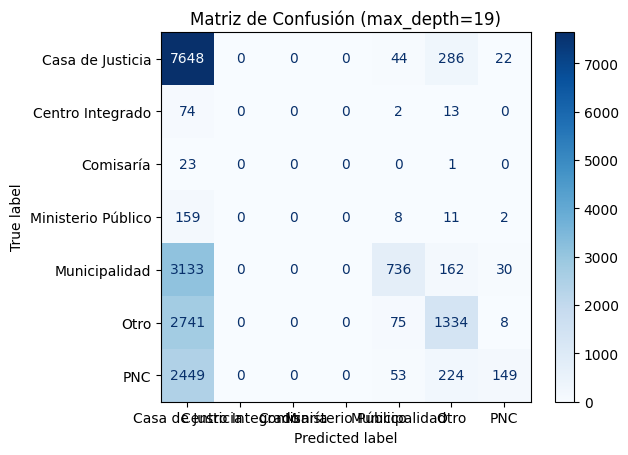

In [102]:
plt.figure(figsize=(16, 12))
disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=rf_pipeline.named_steps['rf'].classes_,
    cmap=plt.cm.Blues,
    normalize=None
)
plt.title(f'Matriz de Confusión (max_depth={best["max_depth"]})')
plt.show()

##### Reporte de clasificación

In [96]:
print(classification_report(y_test, y_pred))


                    precision    recall  f1-score   support

  Casa de Justicia       0.49      0.92      0.64      8000
  Centro Integrado       0.00      0.00      0.00        89
         Comisaría       0.00      0.00      0.00        24
Ministerio Público       0.00      0.00      0.00       180
     Municipalidad       0.77      0.22      0.34      4061
              Otro       0.59      0.41      0.49      4158
               PNC       0.60      0.09      0.15      2875

          accuracy                           0.53     19387
         macro avg       0.35      0.23      0.23     19387
      weighted avg       0.58      0.53      0.46     19387



c:\Users\n8nug\Documents\Uni\2025 - 1er Semestre\Minería de Datos\DM-PR3\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\n8nug\Documents\Uni\2025 - 1er Semestre\Minería de Datos\DM-PR3\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\n8nug\Documents\Uni\2025 - 1er Semestre\Minería de Datos\DM-PR3\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_

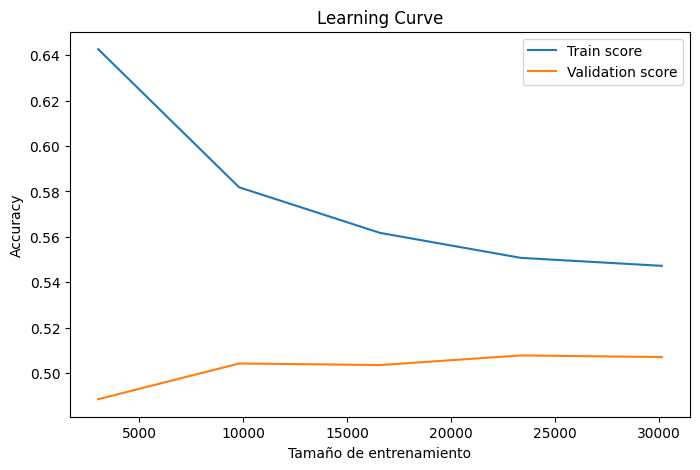

In [103]:

train_sizes, train_scores, val_scores = learning_curve(
    rf_pipeline,
    X_train, y_train,
    cv=3,
    scoring="accuracy",
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
val_mean   = val_scores.mean(axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, label="Train score")
plt.plot(train_sizes, val_mean, label="Validation score")
plt.xlabel("Tamaño de entrenamiento")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend()
plt.show()